# Analyse Interpolated PSF


Analyse the Interpolate the PSF within the simulated ray grid

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : June 4rd 2020


In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import cm

In [44]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [45]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [46]:
from scipy import interpolate

In [47]:
from sklearn.neighbors import NearestNeighbors

In [48]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [49]:
from datetime import datetime,date

In [50]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

## Constants for conversions

In [51]:
m_to_mm=1000.
mm_to_m=1e-3
mm_to_micr=1e3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [52]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [53]:
deg_to_rad=np.pi/180.

In [54]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [55]:
Tel_Focal_Length=20.6 # m : Focal length of the telescope
Tel_Diameter=1.2 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
pltscale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [56]:
print("plate_scale={:2.2f} arcsec per mm ".format(pltscale))

plate_scale=10.01 arcsec per mm 


In [57]:
print("1 arsec = {:2.2f} microns".format(1/pltscale*mm_to_micr))

1 arsec = 99.87 microns


In [58]:
1/pltscale*mm_to_micr/2.36*3

126.95532774812064

#### filter

In [59]:
Filt_D=0.2 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [60]:
Det_xpic=10.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=4096 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [61]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [62]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [63]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [64]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [65]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [66]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [67]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [68]:
order="OP1"
order_str="+1"

# Read input files

In [73]:
rayfile_R150="R150_RESAMPLEBEAM_Beam4_Rayfile_484_allwl_m00_m00_out.csv"
rayfile_HOE="HOE_RESAMPLEBEAM_Beam4_Rayfile_484_allwl_m00_m00_out.csv"

# Choose disperser

In [70]:
FLAG_R150 = True
FLAG_HOE = False

In [71]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [74]:
if FLAG_R150:
    input_data_file=rayfile_R150

        
else:
    input_data_file=rayfile_HOE
    

In [75]:
df=pd.read_csv(input_data_file)

In [76]:
df

,Unnamed: 0,X0,Y0,Xccd_400,Xccd_600,Xccd_800,Xccd_1000,Yccd_400,Yccd_600,Yccd_800,Yccd_1000
0,0,-1.683945,2.602642,11.969819,18.000637,24.084517,30.239178,-0.004276,-0.009092,-0.015753,-0.024300
1,1,-3.262877,-4.978737,11.979858,18.020650,24.117982,30.289740,0.009535,0.019449,0.032889,0.049973
2,2,3.968790,5.882099,11.952577,17.957282,24.002956,30.106759,-0.003990,-0.012000,-0.024087,-0.040358
3,3,2.080843,-4.843618,11.956356,17.968766,24.026140,30.145826,0.004849,0.012232,0.022992,0.037221
4,4,1.396804,2.477300,11.957098,17.971908,24.033076,30.158011,-0.002760,-0.006680,-0.012328,-0.019757
...,...,...,...,...,...,...,...,...,...,...,...
78466,78466,-3.829694,-4.141503,11.982569,18.026493,24.128197,30.305626,0.008336,0.016788,0.028177,0.042608
78467,78467,-5.683942,4.100161,11.995106,18.051300,24.169473,30.367818,-0.009581,-0.018631,-0.030610,-0.045627
78468,78468,2.497405,0.412930,11.953146,17.962645,24.016199,30.131101,-0.000383,-0.000997,-0.001899,-0.003097
78469,78469,3.245153,-5.124972,11.953405,17.960747,24.010580,30.120133,0.004109,0.011406,0.022261,0.036768


# Show beam at beginning of tracking

Text(0.5, 0.98, 'filtered circular beam')

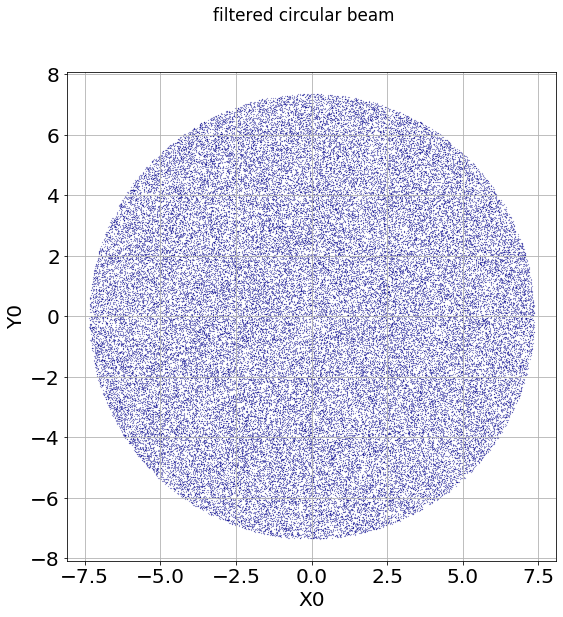

In [77]:
f, ax1 = plt.subplots(figsize=(9,9))
df.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker=".",s=0.1,ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

plt.suptitle("filtered circular beam")

In [78]:
NBEAMS=len(df)

In [79]:
Xccd=df["Xccd_1000"].values
Yccd=df["Yccd_1000"].values

# PSF 2D

Text(0.5, 1.0, ' Random beam on CCD')

<Figure size 864x720 with 0 Axes>

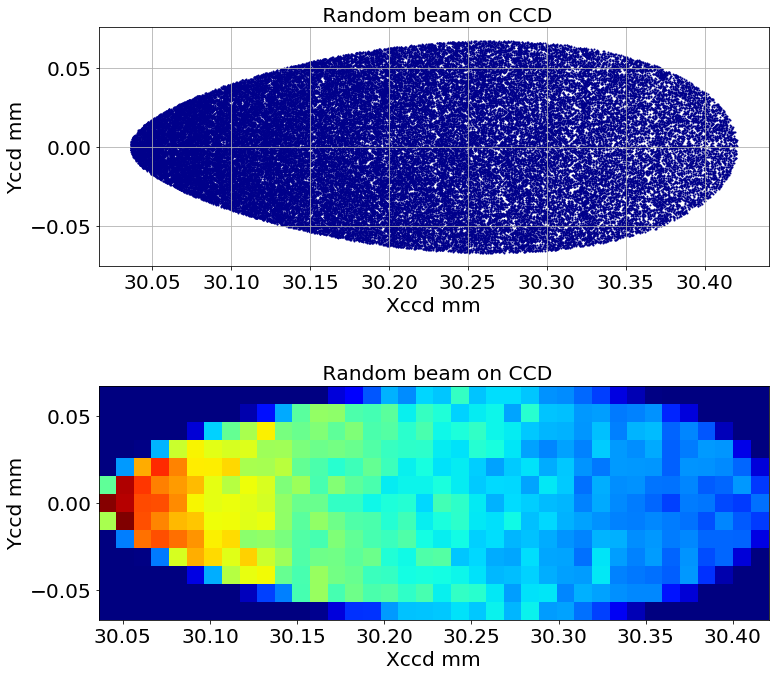

In [80]:
plt.figure(figsize=(12,10))
f, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
NBINX=(Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm)
NBINY=(Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm) 

ax1.scatter(Xccd,Yccd,marker="o" ,color="DarkBlue",s=1)

ax1.grid()
ax1.set_aspect("equal")
ax1.set_xlabel("Xccd mm")
ax1.set_ylabel("Yccd mm")
ax1.set_title(" Random beam on CCD")

ax2.hist2d(Xccd,Yccd,bins=(NBINX,NBINY),cmap=cm.get_cmap('jet', 512))
ax2.set_aspect("equal")
ax2.set_xlabel("Xccd mm")
ax2.set_ylabel("Yccd mm")
ax2.set_title(" Random beam on CCD")

# FWHM

In [81]:
def ComputeFWHM(values,nbins,thetitle="fwhm",thexlabel="X ($\mu m$)",flagplot=False):
    """
    ComputeFWHM(values,nbins,flagplot)
    
    input arg :
       values : list of values
       nbins. : number of bins in the histogram
       flagplot : flag to plot the distribution
    """
    
    counts, bins =np.histogram(values,bins=nbins)
    
    # compute bin width
    binwidths=(np.roll(bins,-1)-bins)[:-1]
    binwidth=np.mean(binwidths)
    
    # find max
    idx_max=np.where(counts==counts.max())[0][0]
    count_max=counts[idx_max]
    counts_halfmax=count_max/2.
    
    # bins above half max
    topmost=np.where(counts>=counts_halfmax)[0]
    idx_min_fwhm=topmost[0]
    idx_max_fwhm=topmost[-1]
    
    # lower upper part
    min_fwhm=bins[idx_min_fwhm]+binwidth/2.
    max_fwhm=bins[idx_max_fwhm]+binwidth/2.
    
    #fwhm
    fwhm=max_fwhm-min_fwhm
    
    
    if flagplot:
        f, ax = plt.subplots(figsize=(10,5))
        
        ax.hist(bins[:-1]+binwidth/2., bins+binwidth/2., weights=counts,facecolor="red",density=False)
        ax.axhline(y=counts_halfmax)
        ax.axvline(x=min_fwhm,color="k")
        ax.axvline(x=max_fwhm,color="k")
        
        ax.grid()
        thetitle=thetitle+" = {:3.0f} $\mu m$".format(fwhm*1000)
        ax.set_title(thetitle)
        ax.set_xlabel(thexlabel)
        
    return fwhm
            

### histogram in CCD pixels

In [82]:
NBINSX=int((Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm))
NBINSY=int((Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm)) 

# compute the histogram
h1=np.histogram(Xccd,bins=NBINSX)
h2=np.histogram(Yccd,bins=NBINSY)

counts1, bins1 = h1
counts2, bins2 = h2


# compute bin width
# compute bin width
binwidths1=(np.roll(bins1,-1)-bins1)[:-1]
binwidth1=np.mean(binwidths1)

binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
binwidth2=np.mean(binwidths2)

# What to fit

theX1=(bins1+binwidth1/2)[:-1]
theY1=counts1

theX2=(bins2+binwidth2/2)[:-1]
theY2=counts2

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev     
    ----------------- ------------------ -----------------
    6045.591769612361 1100.0489914411398 19715.09440845909


Text(0.5, 1.0, 'Marginal PSF$_y$')

<Figure size 864x720 with 0 Axes>

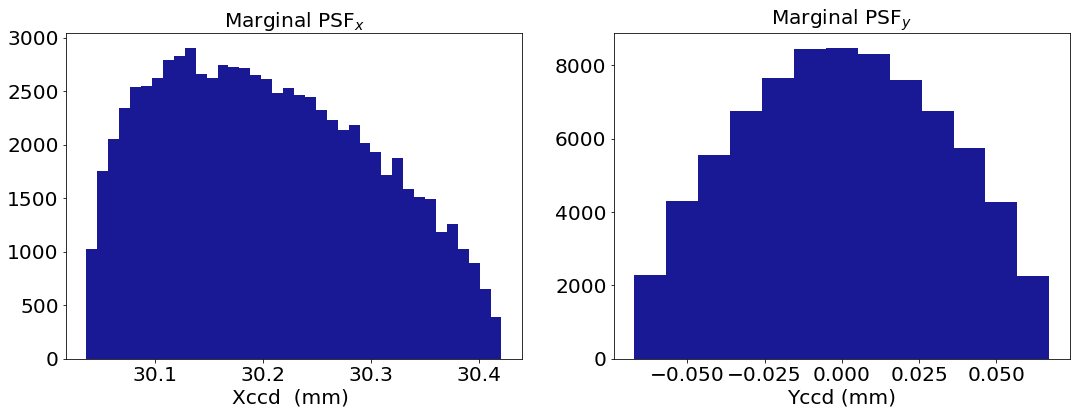

In [83]:
plt.figure(figsize=(12,10))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))


# in X
#ax1.hist(Xccd,bins=NBINSX,facecolor="blue")
ax1.hist(bins1[:-1], bins1, weights=counts1,facecolor="DarkBlue",density=False,alpha=0.9)
ax1.set_xlabel("Xccd  (mm) ")
ax1.set_title("Marginal PSF$_x$")

# in Y
#ax2.hist(Yccd,bins=NBINSY,facecolor="blue")
ax2.hist(bins2[:-1], bins2, weights=counts2,facecolor="DarkBlue",density=False,alpha=0.9)

# gaussian fit
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, theX2,theY2,weights=1)
print(best_fit_gauss)

ax2.set_xlabel("Yccd (mm)")
ax2.set_title("Marginal PSF$_y$")

### Compute FWHM 

0.29972703785970367

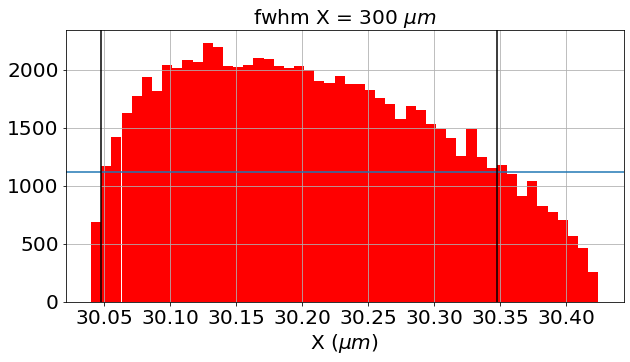

In [84]:
ComputeFWHM(Xccd,50,thetitle="fwhm X",thexlabel="X ($\mu m$)",flagplot=True)

0.09943257138673026

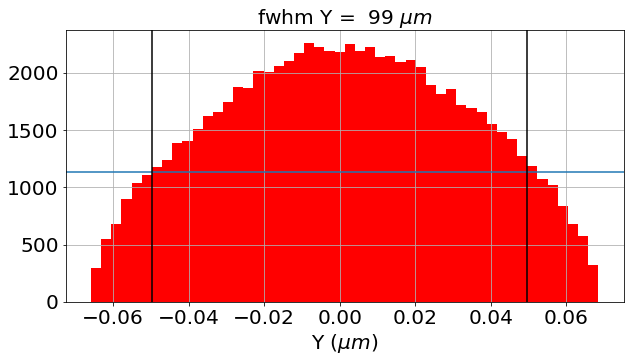

In [85]:
ComputeFWHM(Yccd,50,thetitle="fwhm Y",thexlabel="Y ($\mu m$)",flagplot=True)

# Fit

In [86]:
@custom_model
def exponential(x, a=10., b=1., c=0.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(-np.abs(b*(x-c)))